In [21]:
import sys
import os
import json
import numpy as np
import glob
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_psychophysics_figures
importlib.reload(util_psychophysics_figures)


### SPECIFY THE OUTERMOST DIRECTORY CONTAINING ALL MODELS
model_dir = '/om2/user/msaddler/pitchnet/saved_models/'

### SPECIFY RESULTS DICT BASENAME: determines which experiment to plot
results_dict_basename = 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_AltPhase_v01_bestckpt_results_dict.json'


### SPECIFY REGULAR EXPRESSIONS FOR MODELS: (regex, model_name) pairs
master_list = [
#     ('PND_v04_JWSS_classification*/', 'No lowpass filter'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/', 'Lowpass filtered (1000 Hz cutoff)'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/', 'Lowpass filtered (50 Hz cutoff)'),
    ('arch_0628/PND_v04_JWSS_classification*/', 'arch_0628: No lowpass filter'),
    ('arch_0628/PND_v04_JWSS_ANlowpass1000Hz_classification*/', 'arch_0628: Lowpass filtered (1000 Hz cutoff)'),
    ('arch_0628/PND_v04_JWSS_ANlowpass0050Hz_classification*/', 'arch_0628: Lowpass filtered (50 Hz cutoff)'),
    
#     ('arch_0628/PND_v04_JWSS_classification*/', 'arch_0628 PND_v04_JWSS'),
#     ('arch_0628/PND_v04_JWSS_highpass_v00_classification*/', 'arch_0628 PND_v04_JWSS_highpass_v00'),

#     ('PND_v04_TLAS_classification*/', 'arch_Test PND_v04_TLAS'),
#     ('arch_0628/PND_v04_TLAS_classification*/', 'arch_0628 PND_v04_TLAS'),
#     ('arch_0703/PND_v04_TLAS_classification*/', 'arch_0703 PND_v04_TLAS'),
#     ('PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_Test PND_v04_TLAS_HLPv02'),
#     ('arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0628 PND_v04_TLAS_HLPv02'),
#     ('arch_0703/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0703 PND_v04_TLAS_HLPv02'),

#     ('PND_v04_JWSS_classification*/', 'CarneyModel + JWSS noise'),
#     ('models_RSB/PND_v04_JWSS_classification*/', 'RSBModel + JWSS noise'),
#     ('PND_v04_TLAS_classification*/', 'CarneyModel + TLAS noise'),
#     ('models_RSB/PND_v04_TLAS_classification*/', 'RSBModel + TLAS noise'),

#     ('PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'CarneyModel TLAS noise'),
#     ('models_RSB/PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSBModel TLAS noise'),
#     ('PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'CarneyModel JWSS noise'),
#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSBModel JWSS noise'),
    
#     ('PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
#     ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),
#     ('PND_v04_JWSS_highpass_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '100% highpass filt signal'),

#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),
    
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_test_rsb2xBW_results_dict.json', 'Train 1x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_test_rsb3xBW_results_dict.json', 'Train 1x BW, Test 3x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 2x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Train 3x BW, Test 3x BW'),

#     ('PND_v04_JWSS_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to ~5000 Hz'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 1000 Hz'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 50 Hz'),

#     ('PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'Carney model, PND_v04_JWSS'),
#     ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('PND_v04_JWSS_halfbandpass_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% bandpass filt signal'),
#     ('PND_v04_JWSS_highpass_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '100% highpass filt signal'),
    
#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSB model, PND_v04_JWSS'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% bandpass filt signal'),

]

### LOAD PSYCHOPHYSICS EXPERIMENT RESULTS
model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    if '.json' not in fn_regex: fn_regex = os.path.join(fn_regex, results_dict_basename)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, results_dict_basename))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))


Loaded results from 9 files (EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json)
arch_0628: Lowpass filtered (1000 Hz cutoff) 3
arch_0628: Lowpass filtered (50 Hz cutoff) 3
arch_0628: No lowpass filter 3


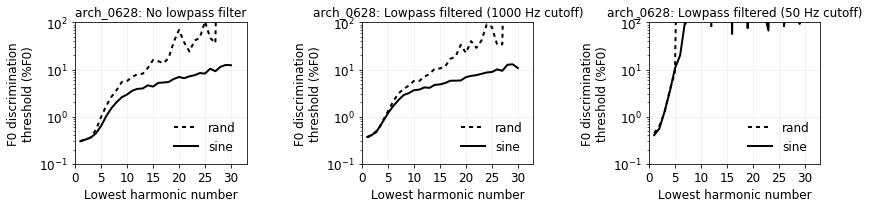

In [22]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)

NCOLS = 3
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
#     util_psychophysics_figures.make_bernox_threshold_plot(ax, human_results_dict,
#                                                            title_str=None, legend_on=False,
#                                                            sine_plot_kwargs={'color':'r', 'lw':0.5*2},
#                                                            rand_plot_kwargs={'color':'r', 'lw':0.5*2, 'dashes':(2, 2)})
    util_psychophysics_figures.make_bernox_threshold_plot(ax, results_dict_input,
                                                          restrict_phase_modes=None,
                                                          title_str=title_str, legend_on=True,
                                                          include_yerr=False,
                                                          sine_plot_kwargs={'color':'k', 'lw':2},
                                                          rand_plot_kwargs={'color':'k', 'lw':2, 'dashes':(2, 2)})
    ax.grid(color=[0.9, 0.9, 0.9], linestyle='-', linewidth=0.5)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_bernox.pdf', bbox_inches='tight')



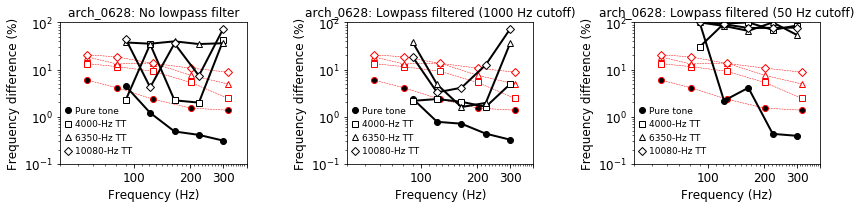

In [16]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_transposedtones()

NCOLS = 3
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_TT_threshold_plot(ax, human_results_dict,
                                                      title_str=None, legend_on=False,
                                                      plot_kwargs_update={'color': 'r', 'ls':'--', 'lw':0.5, 'ms':6})
    util_psychophysics_figures.make_TT_threshold_plot(ax, results_dict_input,
                                                      title_str=title_str,
                                                      legend_on=True,
                                                     include_yerr=False)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_transposedtones.pdf', bbox_inches='tight')


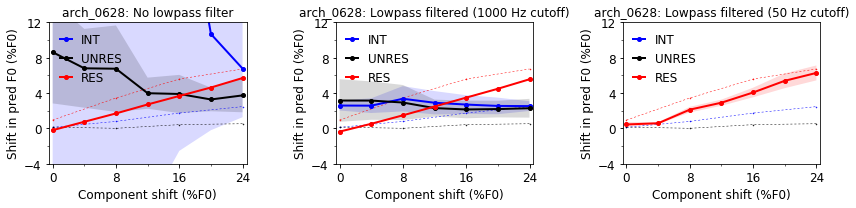

In [18]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(average_conditions=True)

NCOLS = 3
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_freqshiftedcomplexes_plot(ax, human_results_dict,
                                                              expt_key='spectral_envelope_centered_harmonic',
                                                              pitch_shift_key='f0_pred_shift_median',
                                                              condition_plot_kwargs={},
                                                              plot_kwargs_update={'ls':'--', 'lw': 0.5, 'ms':1, 'dashes':(4, 4)},
                                                              legend_on=False,
                                                              include_yerr=True)
    util_psychophysics_figures.make_freqshiftedcomplexes_plot(ax, results_dict_input,
                                                              expt_key='spectral_envelope_centered_harmonic',
                                                              pitch_shift_key='f0_pred_shift_median',
                                                              pitch_shift_key_stddev=None,
                                                              condition_plot_kwargs={},
                                                              plot_kwargs_update={},
                                                              title_str=title_str,
                                                              legend_on=True,
                                                              include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_freqshiftedcomplexes.pdf', bbox_inches='tight')


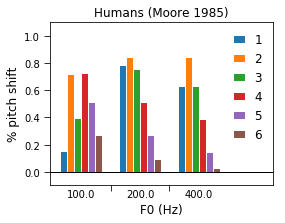

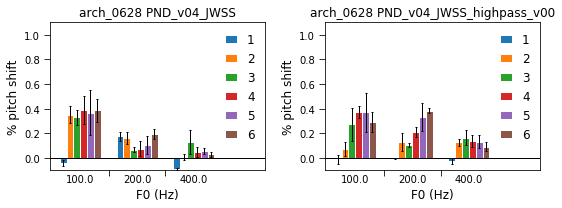

In [54]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*1, 3*1))
util_psychophysics_figures.make_mistuned_harmonics_bar_graph(ax, human_results_dict,
                                                             pitch_shift_key='f0_pred_pct_median',
                                                             title_str='Humans (Moore 1985)',
                                                             legend_on=True)
plt.show()


NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_mistuned_harmonics_bar_graph(ax, results_dict_input,
                                                                 mistuned_pct=3.0,
                                                                 pitch_shift_key='f0_pred_pct_median',
                                                                 pitch_shift_key_stddev=None,
                                                                 title_str=title_str,
                                                                 legend_on=True,
                                                                 include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_mistunedharmonics.pdf', bbox_inches='tight')


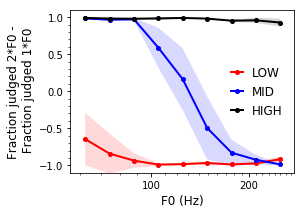

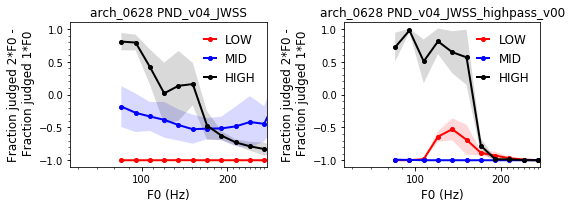

In [50]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*1, 3*1))
util_psychophysics_figures.make_altphase_plot(ax, human_results_dict,
                                              expt_key='filter_fl_bin_means',
                                              expt_key_stddev=None,
                                              condition_plot_kwargs={},
                                              plot_kwargs_update={},
                                              title_str=None,
                                              legend_on=True,
                                              include_yerr=True)
plt.show()

NCOLS = 2
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_altphase_plot(ax, results_dict_input,
                                                  expt_key='filter_fl_bin_means',
                                                  expt_key_stddev=None,
                                                  condition_plot_kwargs={},
                                                  plot_kwargs_update={},
                                                  title_str=title_str,
                                                  legend_on=True,
                                                  include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/2019SEP25_PNDv04_JWSSvsTLAS_CarneyvsRSB_altphasecomplexes.pdf', bbox_inches='tight')
